# Forschungspraktikum SS20 
# Semantic Differentials for Wikipedia using the POLAR Framework


The POLAR Framework is a method that enables Interpretability for pre-trained word embeddings. The goal of this project is to produce word embeddings from a Wikipedia dataset, and deploy the POLAR framework to different categories of words (e.g. Countries, Politicians, Music, etc) in order to explain the semantic associations behind concepts on Wikipedia. An evaluation setup should assess the quality of the semantic differentials produced.

In [1]:

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus #https://radimrehurek.com/gensim/corpora/wikicorpus.html
from gensim.models.word2vec import Word2Vec

# Only run next cell if a new Wikipedia dataset is loaded

In [2]:
trainNewModel=False
loadNewDataset= False

In [3]:
if trainNewModel==True:
    wiki = WikiCorpus(r"C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\enwiki-20200401-pages-articles-multistream1.xml-p1p30303.bz2", 
                  lemmatize=False, dictionary={})
    #stores the preprocessed dataset, which reduces runtime for the future
    wiki.save('SavedWord2Vec/wiki.corpus')
    
    sentences = list(wiki.get_texts()) #Iterate over the dump, yielding a list of tokens for each article that passed the length and namespace filtering.



size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this 
count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW.

In [51]:
### Compute the Word2Vec model usint following parameters#
# Currently using CBOW for testing because of performance issues of skip gram on my laptop #
if trainNewModel==True:
    print("Training Word2Vec model ...")
    params = {'size': 300, 'window': 5, 'min_count': 5, 
          'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,'sg' : 1}
    word2vec = Word2Vec(sentences, **params)
    ### Save Word2Vec model to file ###
    word2vec.save('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Training")
else:
    ### Loading finished Word2Vec model to memory from file ###
    print("Loading Word2Vec model from file...")
    word2vec = Word2Vec.load('SavedWord2Vec/wiki.word2vec.model')
    print("Finished Loading")


Loading Word2Vec model from file...
Finished Loading


In [5]:
female_king = word2vec.most_similar_cosmul(positive='donald'.split(), 
                                           negative='mtu'.split(), topn=5,)
for ii, (word, score) in enumerate(female_king):
    print("{}. {} ({:1.2f})".format(ii+1, word, score))


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  


1. griffiths (1.49)
2. earle (1.49)
3. lindsay (1.49)
4. lester (1.48)
5. melania (1.47)


In [7]:
def similarityNameVector(vec, name):
    
    cosineSimilarity = np.dot(vec, word2vec.wv[name])/(np.linalg.norm(vec)* np.linalg.norm(word2vec.wv[name]))
    return cosineSimilarity

print(similarityNameVector(ourQueen,'queen'))



0.58086324


In [8]:
print("Smiliarity of king and queen:", word2vec.wv.similarity('king', 'queen'))
ourQueen= word2vec.wv['king'] - word2vec.wv['man'] + word2vec.wv['woman']
print("Smiliarity of transformed king and queen:", similarityNameVector(ourQueen,'queen'))

word2vec.wv.most_similar(positive=[ourQueen], topn=10)




Smiliarity of king and queen: 0.61206675
Smiliarity of transformed king and queen: 0.58086324


[('king', 0.7404661178588867),
 ('queen', 0.5808632373809814),
 ('regnant', 0.5323577523231506),
 ('woman', 0.5306766629219055),
 ('consort', 0.4988700747489929),
 ('sibylla', 0.4976164400577545),
 ('monarch', 0.49684637784957886),
 ('berengaria', 0.4891374111175537),
 ('husband', 0.48792698979377747),
 ('isabeau', 0.4850718677043915)]

In [9]:
print(word2vec.wv.similarity('germany', 'europe')) 
print(word2vec.wv.similarity('leyen', 'europe'))

0.52884626
0.23710738


However, Euclidian similarity cannot work well for the high-dimensional word vectors.
This is because Euclidian similarity will increase as the number of dimensions increases, even if the word embedding stands for different meanings.
Alternatively, we can use cosine similarity to measure the similarity between two vectors.
Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. The cosine similarity captures the angle of the word vectors and not the magnitude. Under cosine similarity, no similarity is expressed as a 90-degree angle while the total similarity of 1 is at a 0-degree angle.

In [10]:
word2vec.wv.similarity('star', 'hollywood')  
#'köln', 'akademie'

0.41214263

In [11]:
word2vec.wv.most_similar('afghanistan')[:20]

[('afghan', 0.7354598641395569),
 ('iran', 0.7224469184875488),
 ('kabul', 0.714802086353302),
 ('iraq', 0.7087748050689697),
 ('pakistan', 0.6993895769119263),
 ('taliban', 0.6594675779342651),
 ('tajikistan', 0.6579927206039429),
 ('herat', 0.6495062708854675),
 ('kargil', 0.6288100481033325),
 ('kandahar', 0.6270360946655273)]

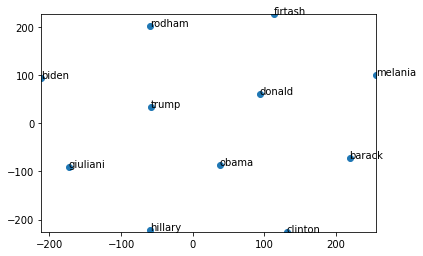

In [13]:
from sklearn.manifold import TSNE
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.wv.similar_by_word(word)
    #print(arr)
    #print(np.array([model[word]]))
    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

    
display_closestwords_tsnescatterplot(word2vec, 'trump', 300) 

# Online training / Resuming training

Advanced users can load a model and continue training it with more sentences and new vocabulary words:

model = gensim.models.Word2Vec.load(temporary_filepath)
more_sentences = [
    ['Advanced', 'users', 'can', 'load', 'a', 'model',
     'and', 'continue', 'training', 'it', 'with', 'more', 'sentences']
]
model.build_vocab(more_sentences, update=True)
model.train(more_sentences, total_examples=model.corpus_count, epochs=model.iter)

cleaning up temporary file
import os
os.remove(temporary_filepath)

In [14]:
import numpy as np
import gensim
from numpy import linalg

from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile

from gensim.test.utils import datapath
#%load_ext autotime

In [15]:
current_model=model = word2vec

In [16]:
list_antonym = []

with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\LenciBenotto.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))


with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\LenciBenotto.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\EVALution.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open(r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Antonym_sets\EVALution.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
                
list_antonym = list(dict.fromkeys(list_antonym).keys())

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).


In [17]:
print(list_antonym[0:50])
print(len(list_antonym))

[('implicate', 'exclude'), ('assertion', 'rejection'), ('terminal', 'beginning'), ('lop', 'secure'), ('pastor', 'libertine'), ('pocket', 'hook'), ('orbital', 'stationary'), ('evidence', 'disprove'), ('psychological', 'biological'), ('preparedness', 'unprepared'), ('saturation', 'dehydration'), ('geologic', 'biologic'), ('accessibility', 'secured'), ('fight', 'agree'), ('lump', 'smooth'), ('double', 'half'), ('training', 'forgetting'), ('determined', 'negligent'), ('velocity', 'still'), ('shield', 'vulnerable'), ('measurement', 'guess'), ('iconic', 'ordinary'), ('thump', 'caress'), ('stretcher', 'compressor'), ('allude', 'distract'), ('cemetery', 'birthplace'), ('corrupt', 'sanctify'), ('cameraman', 'actor'), ('knowledgeable', 'uninformed'), ('screech', 'talk'), ('hedge', 'squander'), ('aggregate', 'please'), ('constrict', 'open'), ('make', 'break'), ('normative', 'descriptive'), ('inscribe', 'polish'), ('bulge', 'hollow'), ('edit', 'expand'), ('sensory', 'numb'), ('immobilize', 'move')

In [18]:
similarity_matrix = defaultdict(list)
print(similarity_matrix)
for each_pair in tqdm(list_antonym):
    word1 = each_pair[0]
    word2 = each_pair[1]
    #print(each_pair)
    #print(word1 < word2)
    
    if word1 < word2: ## welches wort länger ist
        similarity_matrix[word1].append(word2)                  #defaultdict(<class 'list'>, {'exclude': ['inscribe']})
        #print(similarity_matrix)
    else:
        similarity_matrix[word2].append(word1)
    
all_similarity = defaultdict(dict)
for each_key in tqdm(similarity_matrix):
    for each_value in similarity_matrix[each_key]:
#         cosine_similarity([current_model[each_key]]
        all_similarity[each_key][each_value] = abs(cosine_similarity([current_model.wv[each_key]],[current_model.wv[each_value]])[0][0])
        #print(current_model[each_key])
        #print(current_model[each_value])
        #print(all_similarity[each_key][each_value])
       
final_antonym_list = []
for index_counter, each_key in enumerate(tqdm(all_similarity)):
#     print(each_key,all_similarity[each_key])
    listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
    #print(listofTuples)
    final_antonym_list.append((each_key, listofTuples[0][0]))
 
print(final_antonym_list)

list_antonym = final_antonym_list

defaultdict(<class 'list'>, {})


[('exclude', 'inscribe'), ('assertion', 'lazy'), ('beginning', 'terminal'), ('lop', 'secure'), ('libertine', 'pastor'), ('hook', 'pocket'), ('orbital', 'stable'), ('disprove', 'document'), ('biological', 'psychological'), ('preparedness', 'unplanned'), ('dehydration', 'saturation'), ('biologic', 'geologic'), ('accessibility', 'secured'), ('agree', 'crab'), ('lump', 'spread'), ('double', 'indivisible'), ('forgetting', 'training'), ('determined', 'lazy'), ('still', 'velocity'), ('shield', 'vulnerable'), ('guess', 'measurement'), ('iconic', 'ordinary'), ('caress', 'punch'), ('compressor', 'stretcher'), ('allude', 'declare'), ('birthplace', 'cemetery'), ('corrupt', 'honor'), ('actor', 'cameraman'), ('knowledgeable', 'naive'), ('screech', 'talk'), ('hedge', 'plain'), ('aggregate', 'please'), ('constrict', 'release'), ('break', 'connect'), ('descriptive', 'normative'), ('inscribe', 'polish'), ('bulge', 'compress'), ('edit', 'include'), ('numb', 'sensory'), ('immobilize', 'tour'), ('iodine', 

In [19]:
print(len(list_antonym))

1409


In [20]:
num_antonym = 50#1468

In [21]:
## Find the antonym difference vectors
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model.wv[each_word_pair[0]]- current_model.wv[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)

(1409, 300)


In [37]:
print(list_antonym[2])

('beginning', 'terminal')


## Subset Dimension Selection Method

In [22]:
import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

t1 = np.array(antonymy_vector)
dimension_similarity_matrix = defaultdict(dict)
for index_1, each_dim1 in enumerate(tqdm(t1)):
    for index_2, each_dim2 in enumerate(t1):
        dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))
        
        
def get_set_score(final_list, each_dim):
    final_output = 0.0
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))
        
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = []
    

    print('working list is ready, shape', working_list.shape)
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    working_position_index.remove(sel_dim)

    
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim)
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        print(test_count,min_dim)
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

## Generate the ORTHOGONAL DIMENSION Order

## Generate the ORTHOGONAL DIMENSION Order

In [190]:
num_antonym = 500
orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  
print(orthogonal_antonymy_vector.shape)
print(orthogonal_antonymy_vector)

working list is ready, shape (1409, 300)


0 745
1 828
2 824
3 32
4 853
5 1040
6 537
7 799
8 1275
9 789
10 954
11 1165
12 284
13 1057
14 217
15 1323
16 939
17 1363
18 714
19 830
20 780
21 492
22 385
23 1031
24 874
25 205
26 1000
27 1012
28 281
29 1318
30 1393
31 125
32 1136
33 784
34 1260
35 722
36 766
37 1187
38 982
39 1049
40 876
41 230
42 123
43 870
44 1266
45 1103
46 330
47 1332
48 975
49 995
50 1074
51 723
52 429
53 567
54 1252
55 1099
56 928
57 1194
58 552
59 150
60 1219
61 1090
62 1369
63 1128
64 1117
65 176
66 815
67 1351
68 924
69 1095
70 1381
71 251
72 1347
73 768
74 936
75 1097
76 317
77 1179
78 786
79 1325
80 1388
81 1256
82 1372
83 104
84 889
85 1320
86 397
87 94
88 1043
89 1246
90 491
91 1085
92 243
93 988
94 1064
95 535
96 1105
97 1156
98 1343
99 1160
100 412
101 126
102 1247
103 1037
104 769
105 1279
106 1201
107 244
108 838
109 1168
110 1354
111 1149
112 1015
113 1401
114 985
115 302
116 1382
117 1342
118 321
119 641
120 1046
121 1206
122 1200
123 476
124 885
125 1330
126 1387
127 1129
128 1203
129 1051
130 129

## Generate the RANDOM DIMENSION Order

## Generate the RANDOM DIMENSION Order

In [24]:
random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))

1409


## Generate the MAXIMUM VARIANCE DIMENSION Order

## Generate the MAXIMUM VARIANCE DIMENSION Order

In [25]:
embedding_size = antonymy_vector.shape[0]   
print('The embedding size is', embedding_size)


variance_antonymy_vector_inverse = np.linalg.pinv(np.transpose(antonymy_vector))

embedding_matrix = []


total_words = 0
for each_word in tqdm(current_model.wv.vocab):
    total_words += 1

    new_vector = np.matmul(variance_antonymy_vector_inverse,current_model[each_word])
    
    embedding_matrix.append(new_vector)


The embedding size is 1409


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [26]:
del new_vector

In [27]:
variance_list = []

embedding_matrix = np.array(embedding_matrix)

for each_dimension in tqdm(range(embedding_matrix.shape[1])):
    variance_list.append(np.var(embedding_matrix[:,each_dimension]))

In [28]:
variance_antonymy_vector = [each for each in sorted(range(len(variance_list)), key=lambda i: variance_list[i], reverse=True)]

In [29]:
del embedding_matrix

In [30]:
del variance_list

# Transformation to polar space

# Transformation to polar space

In [153]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    embedding_size = orthogonal_antonymy_vector.shape[0] #current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.wv.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.wv.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.wv.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])

        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()



# Standard normal transform 

In [154]:
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.wv.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

## Compute the task score for different dimension size

In [191]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [192]:
import subprocess
#dim_size = 500 # Number of POLAR dimenions
antonym_vector_method = orthogonal_antonymy_vector#random_antonym_vector # orthogonal_antonymy_vector, variance_antonymy_vector

In [193]:
curr_dim = len(antonym_vector_method)#dim_size

embedding_path = r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'.bin'
generate_embedding_path(current_model, embedding_path,True,antonym_vector_method, curr_dim)

print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')

std_nrml_embedding_path = r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
standard_normal_dist_model(temp_model, std_nrml_embedding_path)



New model size is 147612 500


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



loading the model
loading done..


C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  



The shape of embedding matrix is (147612, 500)


In [194]:
#curr_dim=500
path=r'C:\Users\Jan\Desktop\PraktikumSS20\Semantic-Differentials-for-Wikipedia-using-the-POLAR-Framework\JanEngler\Praktikum\polarEmbedding'+str(curr_dim)+'_StdNrml.bin'
#f = open(path, "r+b")
#f.seek(0)
#print(f)
word2vecPolar = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
print("Finished Loading")

Finished Loading


In [195]:
word2vecPolar["test"].shape

(500,)

In [140]:
word2vec.wv.most_similar(positive=["queen"], topn=10)

[('elizabeth', 0.6454077959060669),
 ('isabeau', 0.6140128374099731),
 ('margrethe', 0.6124271154403687),
 ('king', 0.6120667457580566),
 ('regnant', 0.6019624471664429),
 ('ranavalona', 0.5951443910598755),
 ('princess', 0.5911498069763184),
 ('salote', 0.5861144065856934),
 ('boleyn', 0.5729297399520874),
 ('consort', 0.5716495513916016)]

In [163]:
word2vecPolar.wv.most_similar(positive=["queen"], topn=10)

C:\Users\Jan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


[('shah', 0.5474339723587036),
 ('king', 0.5038198828697205),
 ('bhumibol', 0.4365009069442749),
 ('monarch', 0.42754533886909485),
 ('isabella', 0.4093480408191681),
 ('ruler', 0.3890846371650696),
 ('regent', 0.38861343264579773),
 ('castile', 0.3847701847553253),
 ('anula', 0.3807584047317505),
 ('alfonso', 0.3760611414909363)]

In [69]:
#print(list_antonym)
count=0
for i in list_antonym:
    #print(type(i))
    if i == ('common', 'royal'):
        print(count)
    count+=1
print(list_antonym[1166])

1166
('common', 'royal')


In [89]:
orthogonal_antonymy_vector

array([1259,  182,  940, 1308, 1323,  399, 1407,  321, 1363, 1382,  870,
        875,  148, 1202,  522, 1400, 1205,  723,  848, 1076,  293, 1374,
       1332,  782,  316, 1078, 1074,  429,  981,  653,  397, 1285, 1339,
       1236, 1260, 1321, 1275,  975,  995,  862,  411,  612,  442, 1247,
       1248,  683,  668,   87,  475,  784])

In [90]:
for i in orthogonal_antonymy_vector:
    print(list_antonym[i])

('dream', 'real')
('insured', 'uninsured')
('bounce', 'roll')
('beach', 'sea')
('both', 'one')
('dry', 'river')
('fasten', 'loose')
('documentary', 'parody')
('needle', 'thread')
('tell', 'watch')
('different', 'same')
('center', 'side')
('supervised', 'unsupervised')
('outside', 'room')
('legal', 'unlawful')
('royal', 'subject')
('morning', 'night')
('seen', 'unnoticed')
('age', 'young')
('sky', 'water')
('exceptional', 'modal')
('bike', 'car')
('everybody', 'nobody')
('make', 'nature')
('slowness', 'velocity')
('meat', 'plant')
('professor', 'student')
('demolish', 'polish')
('action', 'rest')
('avoidance', 'intercourse')
('queen', 'shah')
('root', 'trunk')
('handle', 'spout')
('huge', 'small')
('money', 'payment')
('cat', 'mouse')
('crater', 'hill')
('credit', 'tax')
('long', 'second')
('back', 'main')
('harmony', 'rivalry')
('aggressor', 'caretaker')
('concentration', 'distribution')
('school', 'work')
('screen', 'stage')
('oceanic', 'shallow')
('depart', 'rendezvous')
('copycat', 

In [196]:
#print(word2vecPolar["screenshot"])
word=word2vecPolar["water"]
#print(word)
#print(list_antonym)
#print(orthogonal_antonymy_vector)
thisdict = {}

indexedList=[]
for count, value in enumerate(word):
    thisdict[count]= value
#print(thisdict)

sortedDic=sorted(thisdict.items(), key=lambda item: abs(item[1]))
sortedDic.reverse()
#print(sortedDic)
for i in range(0,5):
    cur_Index=sortedDic[i][0]
    originalAntonymIndex=orthogonal_antonymy_vector[cur_Index]
    print(originalAntonymIndex)
    print(sortedDic[i][1])
    print(list_antonym[originalAntonymIndex])
    #print(sortedDic[i])

40
-8.3285265
('iodine', 'water')
1069
-5.785868
('grass', 'water')
1219
-3.698965
('oil', 'water')
418
-3.6297088
('germ', 'iodine')
1103
-3.483371
('boss', 'worker')


In [36]:
######### Task specific code....
command_list = ['python3', 
                    r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\classify_task.py',
                     std_nrml_embedding_path,
                     '2',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_train_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_val_y.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_X.pickle',
                     r'C:\Users\Jan\Desktop\PraktikumSS20\POLAR-master\Downstream Task\TREC\data\qa_test_y.pickle'
                    ]



result = subprocess.run(command_list, stdout=subprocess.PIPE, shell=True)
print(result.stdout)
print('finished sentiment task')
################
del temp_model
    
os.remove(std_nrml_embedding_path)
os.remove(embedding_path)

b''
finished sentiment task
